# Feature Selection - LASSO

In [4]:

import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')


import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
my_predictions = {}
my_pred = None
my_actual = None
my_name = None

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# 예측 값과 실제 값을 시각적으로 비교하는 산점도를 그리는 함수
def plot_predictions(name_, pred, actual):

    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

# 주어진 모델의 예측 값과 실제 값으로부터 MSE(Mean Squared Error)를 계산하고 이를 바탕으로 시각화하는 함수
# MSE를 my_predictions 딕셔너리에 저장함
def mse_eval(name_, pred, actual):

    global my_predictions, colors, my_pred, my_actual, my_name
    
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    plot_predictions(name_, pred, actual)
    
    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['mse'], height=0.3)
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('MSE Error', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

# 새로운 모델의 예측 값과 실제 값을 받아 MSE를 계산하고 이를 my_predictions 딕셔너리에 추가하는 함수
def add_model(name_, pred, actual):

    global my_predictions, my_pred, my_actual, my_name
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

# 주어진 이름의 모델을 my_predictions 딕셔너리에서 삭제하는 함수
def remove_model(name_):

    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

# 현재 my_predictions 딕셔너리에 저장된 모든 모델의 MSE 값을 바탕으로 시각화하는 함수
def plot_all():

    global my_predictions, my_pred, my_actual, my_name
    
    plot_predictions(my_name, my_pred, my_actual)
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['mse'], height=0.3)
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('MSE Error', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

# 피처 중요도(또는 회귀 계수)를 바탕으로 가로형 막대 그래프를 그리는 함수 
def plot_coef(columns, coef):

    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

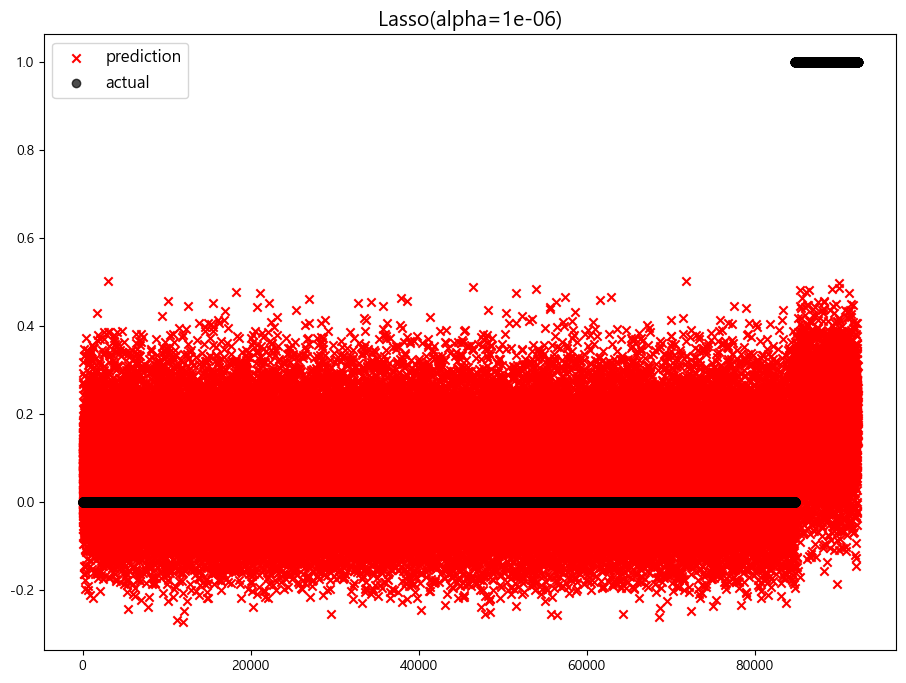

                 model       mse
0     Lasso(alpha=100)  0.074026
1      Lasso(alpha=10)  0.074026
2       Lasso(alpha=1)  0.074026
3     Lasso(alpha=0.1)  0.073866
4    Lasso(alpha=0.01)  0.065568
5   Lasso(alpha=0.001)  0.064637
6  Lasso(alpha=0.0001)  0.064556
7   Lasso(alpha=1e-06)  0.064551


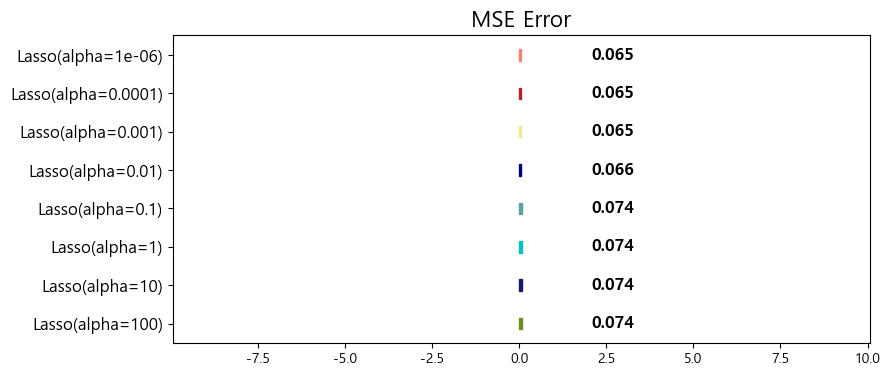

In [23]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import numpy as np
final_VIF_Delete=pd.read_csv(r"C:\Users\Administrator\Desktop\final_VIF_Delete.csv")
final_VIF_Delete=final_VIF_Delete.drop(columns = "Unnamed: 0")
X = final_VIF_Delete.drop(columns = "TARGET")
y = final_VIF_Delete['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 값이 클수록 큰 일반화
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.000001]
for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=111)
    lasso.fit(X_train, y_train)
    pred_lasso = lasso.predict(X_test)
    add_model('Lasso(alpha={})'.format(alpha), pred_lasso, y_test)
plot_all()

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

# 데이터 분할 (훈련 및 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 테스트할 C 값 리스트
c_values = [0.01, 0.1, 1, 10, 100]

# 결과 저장
results = []

for c in c_values:
    # L1-penalized Logistic Regression 모델 정의
    lasso_logreg = LogisticRegression(penalty='l1', C=c, solver='saga', max_iter=5000)
    lasso_logreg.fit(X_train, y_train)

    # 예측 및 F1 스코어 계산
    y_pred = lasso_logreg.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    # 회귀 계수 및 선택된 변수 확인
    coefficients = lasso_logreg.coef_[0]
    feature_names = X_train.columns
    selected_features = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    selected_features = selected_features[selected_features['Coefficient'] != 0]

    # 결과 저장
    results.append({
        'C': c,
        'F1 Score': f1,
        'Selected Features': selected_features['Feature'].tolist()
    })

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 가장 성능이 좋은 C 값과 해당 변수들 출력
best_result = results_df.loc[results_df['F1 Score'].idxmax()]
print("\nBest C value:", best_result['C'])
print("Best F1 Score:", best_result['F1 Score'])
print("Selected Features at Best C:", best_result['Selected Features'])


        C  F1 Score                                  Selected Features
0    0.01  0.154233  [NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR...
1    0.10  0.164589  [NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR...
2    1.00  0.164479  [NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR...
3   10.00  0.164479  [NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR...
4  100.00  0.164479  [NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR...

Best C value: 0.1
Best F1 Score: 0.16458852867830423
Selected Features at Best C: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE

In [25]:
selected_features

,Feature,Coefficient
0,NAME_CONTRACT_TYPE,-0.609739
1,CODE_GENDER,-0.074404
2,FLAG_OWN_CAR,-0.420780
3,FLAG_OWN_REALTY,0.040293
4,CNT_CHILDREN,0.049699
...,...,...
57,NAME_INCOME_TYPE_1.0,-0.104383
58,NAME_INCOME_TYPE_2.0,-0.447028
59,NAME_INCOME_TYPE_3.0,0.005268
60,NAME_FAMILY_STATUS_2.0,-0.051507


라쏘 로지스틱 실행 결과, 기본적인 성능 자체가 좋지 않아서 그런지 변수가 선택이 되지 않고 유의미한 차이를 내지 못함. 따라서 다른 변수 선택 기법으로 추출 후 모델 재 시행행